In [1]:
import numpy as np
import pickle
import galsim
import matplotlib.pyplot as plt

In [5]:
from main import SimCatVal
from utils import sample_position
position = sample_position(1, 67)
ra = position[0][0]
dec = position[0][1]
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)
sample = {'n_images':139.0, 'sigma':2.3588755, 'psf':psf}
simp = {'i': sample}
print(simp)
afw_img, cat, truths, area = SimCatVal('/hildafs/home/pladuca/main/skyCatalog.yaml',ra,dec,1000,50,simp,31.4,True)

2026-01-06 03:11:55,563 - INFO - Catalog data will be read from /hildafs/home/pladuca/main/roman_rubin_cats_v1.1.2_faint/roman_rubin_cats_v1.1.2_faint/


{'i': {'n_images': 139.0, 'sigma': 2.3588755, 'psf': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}
Generating Sims


2026-01-06 03:11:56,802 - INFO - Working on healpix pixel 10307
2026-01-06 03:11:59,807 - INFO - Working on healpix pixel 10307


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4208 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Running Pipeline


  0%|          | 0/1 [00:00<?, ?it/s]

Done!


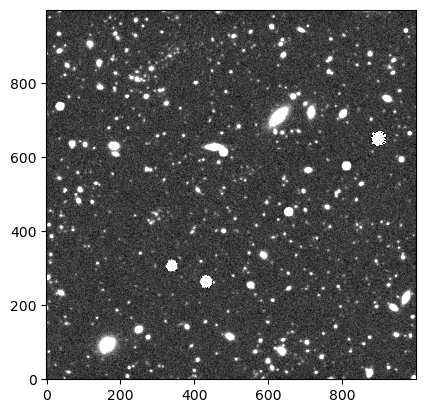

In [6]:
plt.imshow(afw_img['i'].image.array, origin='lower', cmap='gray', vmin=-3,vmax=10)

In [ ]:
#something strange is happening with the stars... could this be from the psf, maybe try simulating just a bright star to see

(13.0, 28.0)

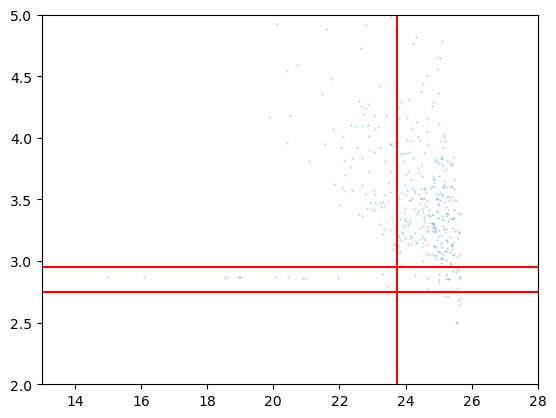

In [7]:
b = 'i'
temp = cat[b]
temp = temp[(temp['deblend_nChild'] == 0) &
    (temp['base_SdssShape_flag'] == False) &
    (temp['modelfit_CModel_instFlux'] >= 0) &
    (temp['modelfit_CModel_flag'] == False) &
    (temp['ext_gaap_GaapFlux_1_15x_Optimal_instFlux'] >= 0) &
    (temp['base_SdssCentroid_flag'] == False) &
    (temp['ext_gaap_GaapFlux_flag'] == False) &
    (temp['base_ClassificationSizeExtendedness_flag'] == False)]
temp = temp[(temp['base_PsfFlux_instFlux']/temp['base_PsfFlux_instFluxErr'] >= 10)]

mag = -2.5 * np.log10(temp['modelfit_CModel_instFlux']) + 31.4
size = np.sqrt(temp['base_SdssShape_xx'] + temp['base_SdssShape_yy'])

plt.scatter(mag, size, s=0.3, alpha=0.3)
# plt.scatter(mag, psf, s=0.3, alpha=0.3)
plt.axhline(2.95, c='r')
plt.axhline(2.75, c='r')
plt.axvline(23.75, c='r')
plt.ylim(2,5)
plt.xlim(13,28)

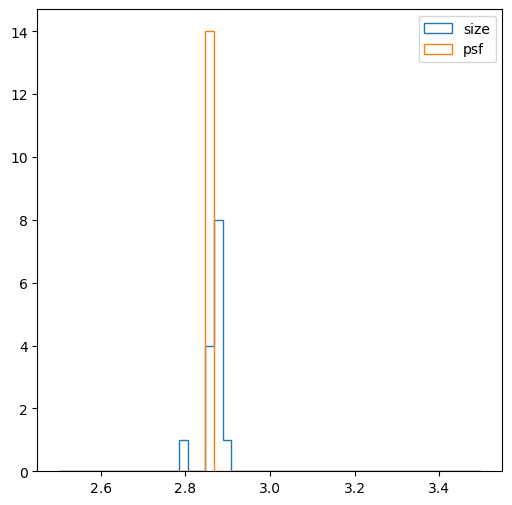

In [8]:
stars = temp[(mag < 23.75) & (size < 2.95) & (size > 2.75)]

size_bins = np.linspace(2.5,3.5,50)
star_size = np.sqrt(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
star_psf = np.sqrt(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(star_size, size_bins, histtype="step", label="size")
plt.hist(star_psf, size_bins, histtype="step", label="psf")
plt.legend()
plt.show()

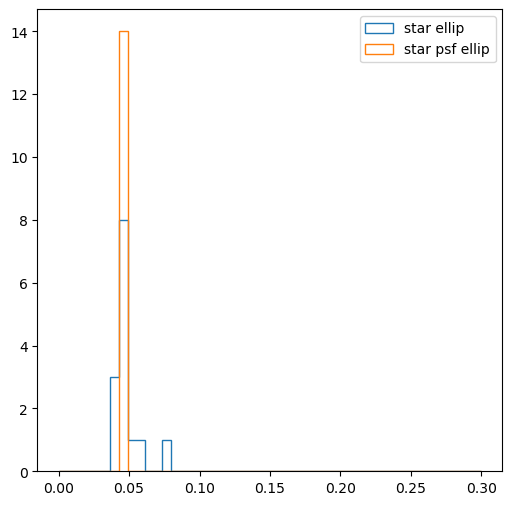

In [9]:
e1 = (stars['base_SdssShape_psf_xx'] - stars['base_SdssShape_psf_yy'])/(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
e2 = 2*(stars['base_SdssShape_psf_xy'])/(stars['base_SdssShape_psf_xx'] + stars['base_SdssShape_psf_yy'])
ellip = np.sqrt((e1)**2 + (e2)**2)

se1 = (stars['base_SdssShape_xx'] - stars['base_SdssShape_yy'])/(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
se2 = 2*(stars['base_SdssShape_xy'])/(stars['base_SdssShape_xx'] + stars['base_SdssShape_yy'])
sellip = np.sqrt((se1)**2 + (se2)**2)

ellip_bins = np.linspace(0,0.3,50)
fig, ax = plt.subplots(figsize=(6,6))
plt.hist(sellip, ellip_bins, histtype="step", label="star ellip")
plt.hist(ellip, ellip_bins, histtype="step", label="star psf ellip")
plt.legend()
plt.show()

# approx zero, consistent with kolmogorov profile

In [2]:
with open('psf_test.pkl', 'rb') as file:
    psf = pickle.load(file)

print(psf)
print(psf.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(35, 35)


In [ ]:
ipsf = galsim.Image(psf)
gpsf = galsim.InterpolatedImage(ipsf, scale=0.2, normalization='flux')
print(gpsf)
print(gpsf.calculateMomentRadius()/0.2) #why is this slightly smaller than measued value from DP1?
print(gpsf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, gpsf)
print(epsf.calculateFWHM()/0.2)

galsim.InterpolatedImage(image=galsim.Image(bounds=galsim.BoundsI(-17,17,-17,17), scale=0.2, dtype=numpy.float64), flux=0.99999999611243)
2.7716448140692163
4.156009037928731
4.225404329113469


In [ ]:
dpsf = galsim.InterpolatedImage(ipsf, scale=0.2, depixelize=True, normalization='flux') #this can account for pixel response, does it affect ellipticity?
print(dpsf.calculateFWHM()/0.2)
pixel = galsim.Pixel(0.2)
epsf = galsim.Convolve(pixel, dpsf)
print(epsf.calculateFWHM()/0.2)

4.160901013601039
